# Baseline LSTM



In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import random

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [62]:
file_name = ".SEED.txt"
with open(file_name, "r") as file:
    content = file.read().strip()  # Read and remove any extra whitespace/newlines
    number = int(content)  # Use float() to support decimal; use int() if it's always an integer

print("Seed:", number)
print("Type:", type(number))

Seed: 271828183
Type: <class 'int'>


In [63]:
CSV_PATH = "ALL_MERGED.csv"     # <--- set your CSV file path
DATE_COL = "Date"
TARGET_COL = "JKSE"
INCLUDE_TARGET_AS_FEATURE = True  # set False to exclude JKSE from X
CHECKPOINT_PATH = "Model Checkpoints/lstm_baseline_checkpoint.keras"
MODEL_NAME = "LSTM_Baseline"

LOOKBACK = 20
TEST_SIZE = 0.20
VAL_SIZE = 0.10
RANDOM_SEED = number
EPOCHS = 100
BATCH_SIZE = 32
LSTM_UNITS = 64
DROPOUT = 0.2
VERBOSE_TRAIN = 1

print(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)

271828183


In [64]:
# Load Dataset & Clean
df = pd.read_csv(CSV_PATH)

# Basic sanity check: required columns
required = [
    "Date","Nickel_Fut","Coal_Fut_Newcastle","Palm_Oil_Fut",
    "USD_IDR","CNY_IDR","EUR_IDR","BTC_USD",
    "FTSE100","HANGSENG","NIKKEI225","SNP500","DOW30","SSE_Composite","JKSE"
]

missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

# Parse date & sort
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).set_index(DATE_COL)

# # --- Keep only 2021–2025 ---
# start_date = pd.Timestamp("2021-01-01")
# end_date   = pd.Timestamp("2025-05-01")

# df = df.loc[(df.index >= start_date) & (df.index <= end_date)].copy()

# # (optional) sanity check
# print("Filtered date range:", df.index.min(), "→", df.index.max(), "| rows:", len(df))
# if len(df) < LOOKBACK + 50:
#     print("Warning: very little data after filtering; consider smaller LOOKBACK or wider range.")

# Fill gaps (time-series friendly)
df = df.ffill().bfill()
df

,Nickel_Fut,Coal_Fut_Newcastle,Palm_Oil_Fut,USD_IDR,CNY_IDR,EUR_IDR,BTC_USD,FTSE100,HANGSENG,NIKKEI225,SNP500,DOW30,SSE_Composite,JKSE
Date,,,,,,,,,,,,,,
2015-05-01,13750.0000,62.2000,2136,12962.5000,2089.7800,14519.9000,232.0790,6986.0000,28123.8203,19531.6309,2108.2900,18024.0605,4480.4639,5140.9370
2015-05-02,13750.0000,62.2000,2136,12962.5000,2089.7800,14519.9000,234.9300,6986.0000,28123.8203,19531.6309,2108.2900,18024.0605,4480.4639,5140.9370
2015-05-03,13750.0000,62.2000,2136,12962.5000,2089.7800,14519.9000,240.3580,6986.0000,28123.8203,19531.6309,2108.2900,18024.0605,4480.4639,5140.9370
2015-05-04,13750.0000,62.2000,2136,12980.0000,2090.5100,14467.5000,239.0180,6986.0000,28123.8203,19531.6309,2114.4900,18070.4004,4480.4639,5140.9370
2015-05-05,14245.0000,62.5000,2136,13047.5000,2102.3900,14594.9000,236.1210,6927.6001,27755.5391,19531.6309,2089.4600,17928.1992,4298.7061,5160.1074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-27,15482.8800,93.7500,4057,16830.0000,2309.3700,19127.3000,93754.8438,8415.2998,21980.7402,35705.7383,5525.2100,40113.5000,3295.0601,6678.9150
2025-04-28,15637.6300,95.6000,3943,16855.0000,2310.5900,19251.8000,94978.7500,8417.2998,21971.9609,35839.9883,5528.7500,40227.5898,3288.4150,6722.9658
2025-04-29,15564.0000,97.2500,3911,16760.0000,2305.5200,19082.1000,94284.7891,8463.5000,22008.1094,35839.9883,5560.8301,40527.6211,3286.6550,6749.0752


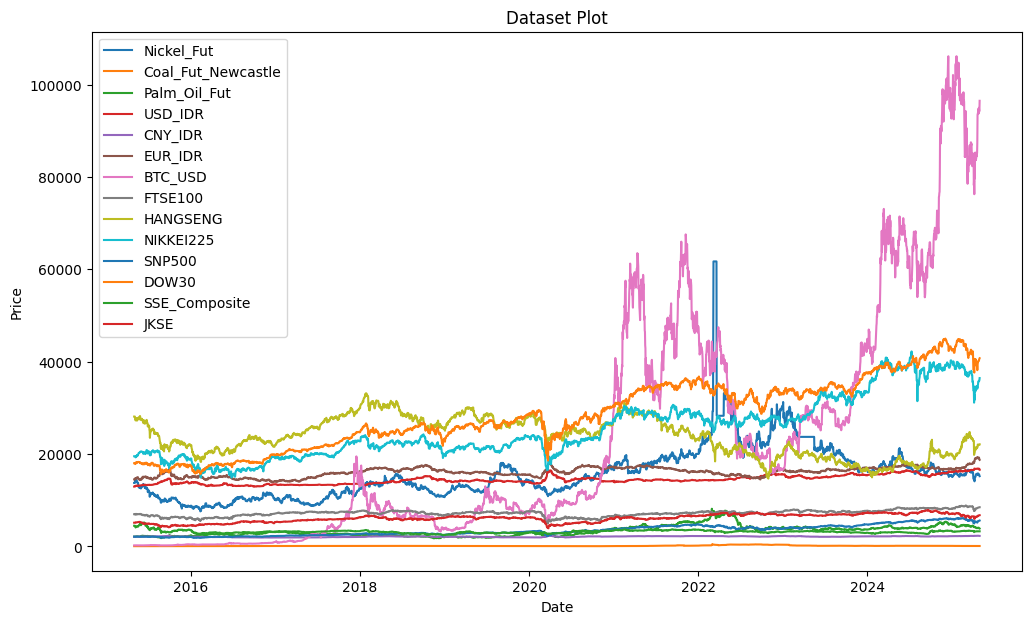

In [65]:
plt.figure(figsize=(12, 7))
plt.plot(df.index, df)
plt.title(f"Dataset Plot")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend(labels=df.columns)
plt.show()

In [66]:
# Train Test Split
n = len(df)
test_n = int(np.floor(TEST_SIZE * n))
trainval_n = n - test_n
val_n = int(np.floor(VAL_SIZE * trainval_n))
train_n = trainval_n - val_n

train_df = df.iloc[:train_n].copy()
val_df   = df.iloc[train_n:train_n + val_n].copy()
test_df  = df.iloc[train_n + val_n:].copy()

print(f"Train: {len(train_df)} | Validation: {len(val_df)} | Test: {len(test_df)}")
print(f"Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%) | Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%) | Test: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")


Train: 2632 | Validation: 292 | Test: 730
Train: 2632 (72.0%) | Validation: 292 (8.0%) | Test: 730 (20.0%)


In [67]:
if INCLUDE_TARGET_AS_FEATURE:
    feature_cols = df.columns.tolist()          # includes TARGET_COL (JKSE)
else:
    feature_cols = [c for c in df.columns if c != TARGET_COL]

In [68]:
# feature_cols = [c for c in df.columns if c != TARGET_COL]
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_scaler.fit(train_df[feature_cols])
y_scaler.fit(train_df[[TARGET_COL]])

def scale_block(block):
    X = X_scaler.transform(block[feature_cols])
    y = y_scaler.transform(block[[TARGET_COL]])
    return pd.DataFrame(X, index=block.index, columns=feature_cols), pd.DataFrame(y, index=block.index, columns=[TARGET_COL])

X_train_s, y_train_s = scale_block(train_df)
X_val_s,   y_val_s   = scale_block(val_df)
X_test_s,  y_test_s  = scale_block(test_df)

In [69]:
def make_windows(X_df, y_df, lookback):
    X_vals = X_df.values
    y_vals = y_df.values.squeeze()
    idx = X_df.index

    X_list, y_list, idx_list = [], [], []
    for i in range(lookback, len(X_df)):
        X_list.append(X_vals[i - lookback:i, :])
        y_list.append(y_vals[i])    # predict next (current) step
        idx_list.append(idx[i])     # timestamp of prediction

    X_arr = np.array(X_list, dtype=np.float32)
    y_arr = np.array(y_list, dtype=np.float32)
    idx_arr = np.array(idx_list)
    return X_arr, y_arr, idx_arr

X_train, y_train, idx_train = make_windows(X_train_s, y_train_s, LOOKBACK)
X_val,   y_val,   idx_val   = make_windows(X_val_s,   y_val_s,   LOOKBACK)
X_test,  y_test,  idx_test  = make_windows(X_test_s,  y_test_s,  LOOKBACK)

In [70]:
model = Sequential([
    Input(shape=(LOOKBACK, len(feature_cols))),
    LSTM(LSTM_UNITS),
    Dropout(DROPOUT),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.summary(line_length=110, expand_nested=True, show_trainable=True)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    # must end with .weights.h5 if save_weights_only=True
    ModelCheckpoint(filepath=CHECKPOINT_PATH,
                    monitor="val_loss",
                    save_best_only=True),
    # ModelCheckpoint("baseline_lstm_jkse.weights.h5",
    #                 monitor="val_loss",
    #                 save_best_only=True,
    #                 save_weights_only=True)
]

start_train = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=VERBOSE_TRAIN
)
end_train = time.time()
print(f"Training time: {end_train - start_train:.4f} seconds")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Layer (type)                              ┃ Output Shape                     ┃          Param # ┃ Trainab… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ lstm_4 (LSTM)                             │ (None, 64)                       │           20,224 │    Y     │
├───────────────────────────────────────────┼──────────────────────────────────┼──────────────────┼──────────┤
│ dropout_4 (Dropout)                       │ (None, 64)                       │                0 │    -     │
├───────────────────────────────────────────┼──────────────────────────────────┼──────────────────┼──────────┤
│ dense_4 (Dense)                           │ (None, 1)                        │               65 │    Y     │
└───────────────────────────────────────────┴──────────────────────────────────┴──────────────────┴──────────┘

 Total params: 20,289 (79.25 KB)

 Trainable params: 20,289 (79.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.5310 - val_loss: 0.1161
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0464 - val_loss: 0.1254
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0344 - val_loss: 0.1730
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0341 - val_loss: 0.1827
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0279 - val_loss: 0.1774
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0241 - val_loss: 0.1526
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0228 - val_loss: 0.1773
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0215 - val_loss: 0.1085
Epoch 9/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0185 - val_loss: 0.1135
Epoch 10/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0190 - val_loss: 0.1165
Epoch 11/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0160 - val_loss: 0.1002
Epoch 12/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0

In [71]:
def predict_block(X_block, idx_block):
    yhat_s = model.predict(X_block, verbose=1)
    yhat = y_scaler.inverse_transform(yhat_s).squeeze()
    return pd.Series(yhat, index=idx_block, name="Pred")

pred_train = predict_block(X_train, idx_train)
pred_val   = predict_block(X_val,   idx_val)

start_test = time.time()
pred_test  = predict_block(X_test,  idx_test)
end_test = time.time()
print(f"Testing (inference) time: {end_test - start_test:.4f} seconds")

actual = df[TARGET_COL]
actual_train = actual.loc[idx_train]
actual_val   = actual.loc[idx_val]
actual_test  = actual.loc[idx_test]

# Train values
y_true_train = actual_train.values
y_pred_train = pred_train.values

# Validation values
y_true_val = actual_val.values
y_pred_val = pred_val.values

# Test values
y_true_test = actual_test.values
y_pred_test = pred_test.values

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Testing (inference) time: 0.1204 seconds


In [72]:
def compute_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return [mse, mae, rmse, mape, r2]

# Compute for each split
metrics_train = compute_metrics(actual_train.values, pred_train.values)
metrics_val   = compute_metrics(actual_val.values,   pred_val.values)
metrics_test  = compute_metrics(actual_test.values,  pred_test.values)

# Build DataFrame
metrics_df = pd.DataFrame(
    [metrics_train, metrics_val, metrics_test],
    columns=["MSE", "MAE", "RMSE", "MAPE", "R²"],
    index=["Train", "Validation", "Test"]
)

pd.set_option("display.float_format", "{:.4f}".format)
print("\n=== Metrics Summary ===")
print(metrics_df)


=== Metrics Summary ===
                   MSE      MAE     RMSE   MAPE      R²
Train        4722.1881  51.7096  68.7182 0.0091  0.9906
Validation  12157.5232  86.4969 110.2612 0.0123  0.5528
Test       114538.3515 291.8002 338.4352 0.0403 -0.0110


In [73]:
residuals = pd.Series(y_true_test - y_pred_test, index=idx_test, name="Residuals")

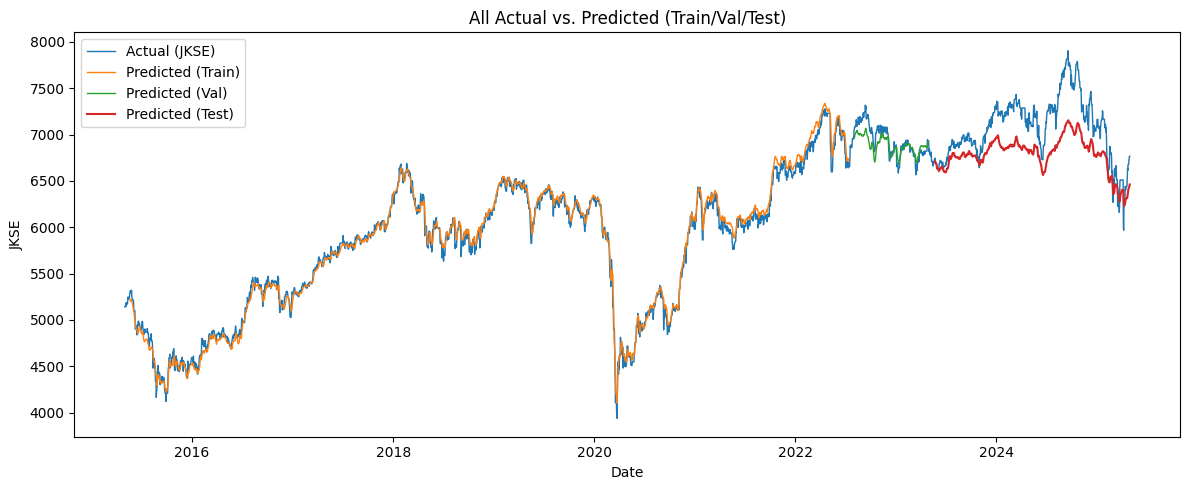

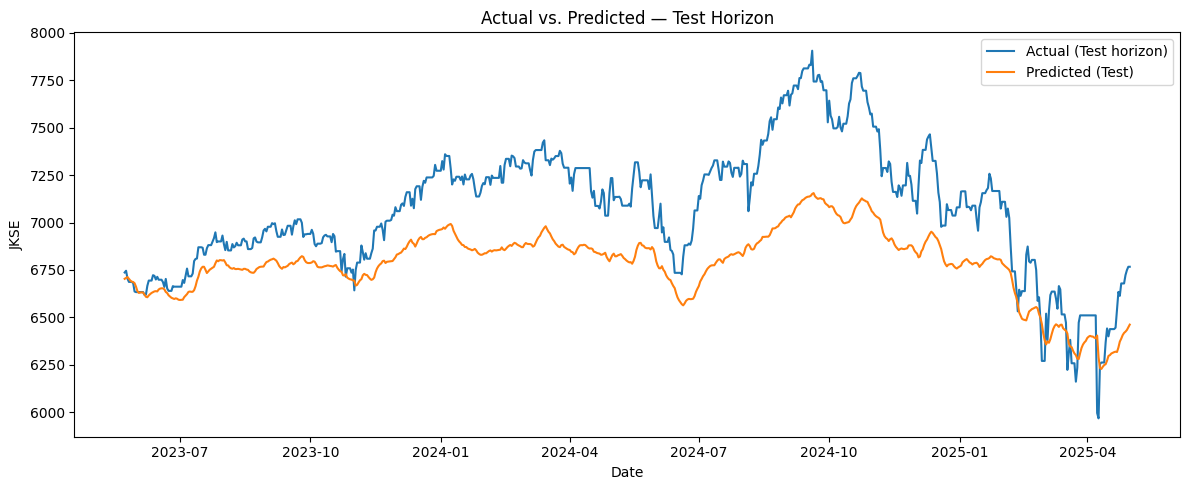

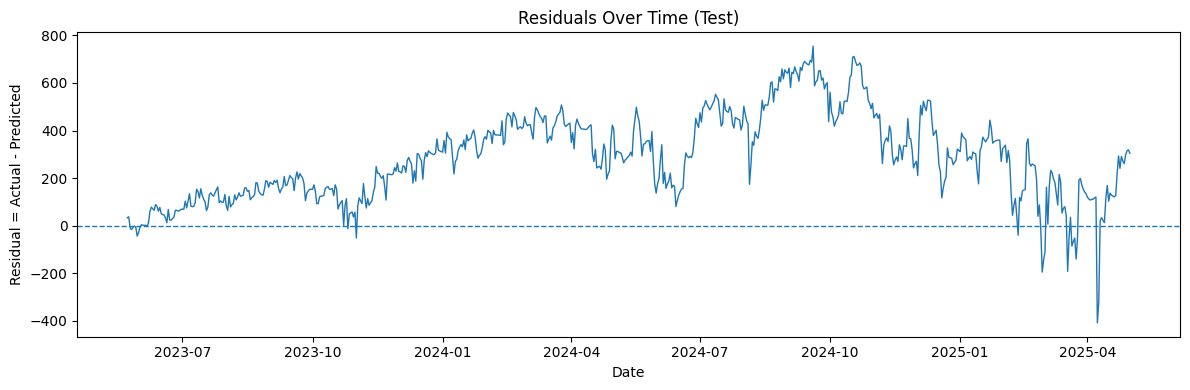

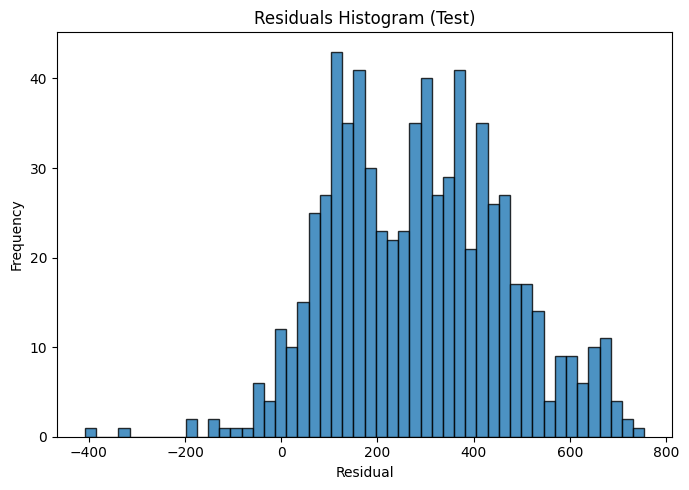

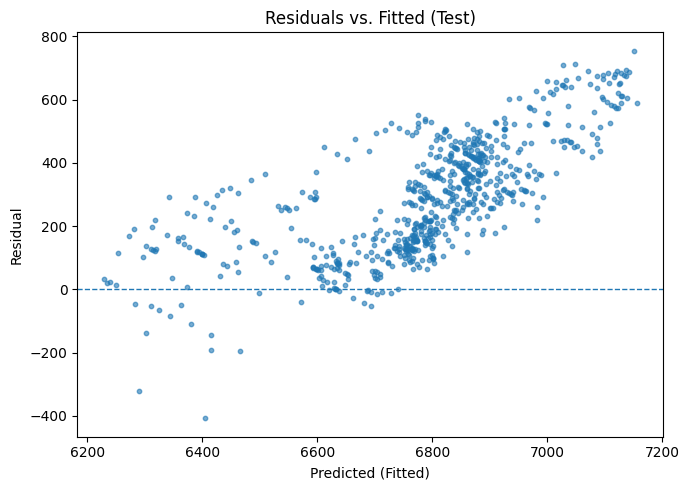

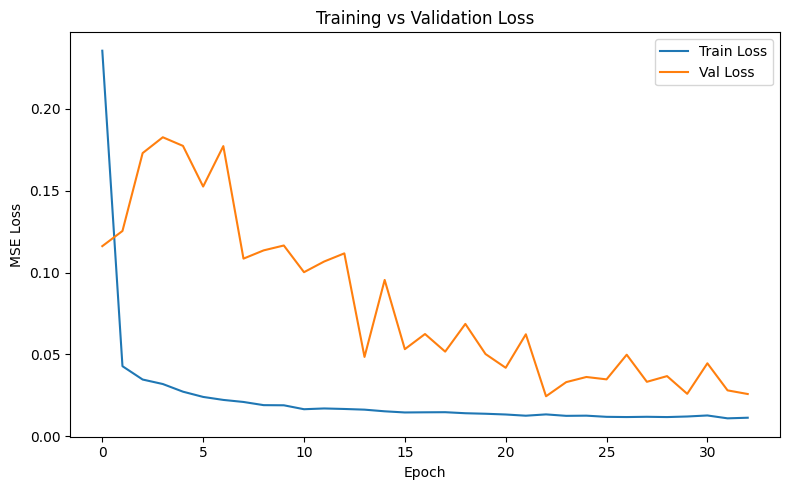

In [74]:
# 1) All actual vs predicted (train/val/test)
plt.figure(figsize=(12, 5))
plt.plot(actual.index, actual.values, label="Actual (JKSE)", linewidth=1)
plt.plot(pred_train.index, pred_train.values, label="Predicted (Train)", linewidth=1)
plt.plot(pred_val.index, pred_val.values, label="Predicted (Val)", linewidth=1)
plt.plot(pred_test.index, pred_test.values, label="Predicted (Test)", linewidth=1.5)
plt.title("All Actual vs. Predicted (Train/Val/Test)")
plt.xlabel("Date"); plt.ylabel("JKSE")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Actual vs predicted on the prediction (test) timeline only
plt.figure(figsize=(12, 5))
plt.plot(actual_test.index, actual_test.values, label="Actual (Test horizon)", linewidth=1.5)
plt.plot(pred_test.index,   pred_test.values,   label="Predicted (Test)", linewidth=1.5)
plt.title("Actual vs. Predicted — Test Horizon")
plt.xlabel("Date"); plt.ylabel("JKSE")
plt.legend()
plt.tight_layout()
plt.show()

# 3) Residuals over time
plt.figure(figsize=(12, 4))
plt.plot(residuals.index, residuals.values, linewidth=1)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Residuals Over Time (Test)")
plt.xlabel("Date"); plt.ylabel("Residual = Actual - Predicted")
plt.tight_layout()
plt.show()

# 4) Residual histogram
plt.figure(figsize=(7, 5))
plt.hist(residuals.values, bins=50, edgecolor="black", alpha=0.8)
plt.title("Residuals Histogram (Test)")
plt.xlabel("Residual"); plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 5) Residual scatter (residuals vs fitted)
plt.figure(figsize=(7, 5))
plt.scatter(pred_test.values, residuals.values, s=10, alpha=0.6)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Residuals vs. Fitted (Test)")
plt.xlabel("Predicted (Fitted)"); plt.ylabel("Residual")
plt.tight_layout()
plt.show()

# 6) Train vs validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [75]:
# === CONFIGURATION ===
results_dir = os.path.join("..", "Results")
predicted_path = os.path.join(results_dir, "ALL_PREDICTED.csv")
metrics_path = os.path.join(results_dir, "ALL_METRICS.csv")

# Manual model name (since __file__ isn't available in notebooks)
model = "lstm_baseline"
model_name = f"{model}_{RANDOM_SEED}"   # change this for each notebook (e.g., GRU_Baseline)
print("Model Name for Documentation:", model_name)

# Create Results directory if not exists
os.makedirs(results_dir, exist_ok=True)

# ==========================================
# 1️⃣ PREPARE AND ALIGN TESTING DATAFRAME
# ==========================================

# Convert dates
test_dates = test_df.index.to_series().reset_index(drop=True)
actual_values = test_df[TARGET_COL].values

# If ALL_PREDICTED doesn't exist, create the base file
if not os.path.exists(predicted_path):
    print("Creating ALL_PREDICTED.csv ...")
    base_df = pd.DataFrame({
        "date": test_dates,
        "actual": actual_values
    })
    base_df.to_csv(predicted_path, index=False)

# Load and ensure datetime consistency
all_pred_df = pd.read_csv(predicted_path)
all_pred_df["date"] = pd.to_datetime(all_pred_df["date"])

# Ensure the file covers full test range (in case it was made from smaller data)
base_df = pd.DataFrame({
    "date": test_dates,
    "actual": actual_values
})
# Outer merge to make sure we have the full timeline
all_pred_df = pd.merge(base_df, all_pred_df, on=["date", "actual"], how="outer")

# Create new prediction column (aligned to date)
pred_series = pd.Series(y_pred_test, index=pd.to_datetime(idx_test), name=model_name)
pred_series = pred_series.reindex(all_pred_df["date"])  # align by date

# Add or update the model column
all_pred_df[model_name] = pred_series.values

# Sort and save
all_pred_df = all_pred_df.sort_values("date").reset_index(drop=True)
all_pred_df.to_csv(predicted_path, index=False)
print(f"✅ Predictions saved to {predicted_path}")

# ==========================================
# 2️⃣ RECORD METRICS SUMMARY
# ==========================================
metrics_columns = [
    "timestamp",
    "model_name", 
    "seed",
    "mse",
    "mae",
    "rmse", 
    "mape",
    "r2_score",
    "picp",
    "mpiw",
    "winkler_score",
    "training_time_s",
    "testing_time_s", 
    "hpo_trial_s",
    "hpo_time_s"
]

# Create ALL_METRICS if missing
if not os.path.exists(metrics_path):
    print("Creating ALL_METRICS.csv ...")
    pd.DataFrame(columns=metrics_columns).to_csv(metrics_path, index=False)

# Current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Extract metrics
mse, mae, rmse, mape, r2 = metrics_test
picp = mpiw = winkler = hpo_trial_s = hpo_time_s = 0

# Build metrics row
metrics_row = {
    "timestamp": timestamp,
    "model_name": model_name,
    "seed": RANDOM_SEED,
    "mse": mse,
    "mae": mae,
    "rmse": rmse,
    "mape": mape,
    "r2_score": r2,
    "picp": picp,
    "mpiw": mpiw,
    "winkler_score": winkler,
    "training_time_s": round(end_train - start_train, 4),
    "testing_time_s": round(end_test - start_test, 4),
    "hpo_trial_s": hpo_trial_s,
    "hpo_time_s": hpo_time_s
}

# Append metrics
all_metrics_df = pd.read_csv(metrics_path)
all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([metrics_row])], ignore_index=True)
all_metrics_df.to_csv(metrics_path, index=False)
print(f"✅ Metrics appended to {metrics_path}")

print("\n📄 Documentation of predictions and metrics completed successfully.")


Model Name for Documentation: lstm_baseline_271828183
✅ Predictions saved to ..\Results\ALL_PREDICTED.csv
✅ Metrics appended to ..\Results\ALL_METRICS.csv

📄 Documentation of predictions and metrics completed successfully.
